# 04 Transfer Entropy

In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../")

import jupyter_black

jupyter_black.load()

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.cleansing as cleansing
from loguru import logger


logger.remove()  # Remove any previous log handlers
logger.add(lambda msg: print(msg), level="INFO")

1

In [3]:
df = pd.read_csv("../data/Weather Data.csv")

# rename columns
# parse datetime column
df = cleansing.clean_weather_data(df)

In [4]:
df.head()

,date_time,temp_c,dew_point_temp_c,real_hum_pct,wind_speed_kmh,visibility_km,press_kpa,weather
0,2012-01-01 00:00:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,2012-01-01 01:00:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,2012-01-01 02:00:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,2012-01-01 03:00:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,2012-01-01 04:00:00,-1.5,-3.3,88,7,4.8,101.23,Fog


In [5]:
# Transfer Entropy uses the conditional mutual information formulation
from src.transfer_entropy import get_transfer_entropy

## The lags

We observed that:
- `temp_c` and `dew_point_temp_c` have high positive correlation
- `visibility_km` and `real_hum_pct` have high negative correlation
- `dew_point_temp_c` and `date_time` also appear to have some correlation

Now, we are going to test their causality relationships.

But first, we need to define the lags - from our interpretation, what lags can we use to find the different causality relationships? 

We have samples of every hour. We can explore the causality between entities with short lags: 1h, 3h; and longer lags; 12h, 24h, 48h

In [6]:
def run_transfer_entropy_for_dataframe(
    df: pd.DataFrame, array_of_lags: list[int], **kwargs
) -> pd.DataFrame:
    numerical_columns = df.select_dtypes(include=[np.number]).columns

    results = []
    # Compare each 2 by 2
    for i in range(len(numerical_columns)):
        for j in range(i + 1, len(numerical_columns)):
            if i != j:
                col_x1 = numerical_columns[i]
                col_x2 = numerical_columns[j]
                for lag in array_of_lags:
                    x1 = df[col_x1].values.tolist()
                    x2 = df[col_x2].values.tolist()
                    te_from_2_to_1 = get_transfer_entropy(
                        target_column=x1, causal_column=x2, lag=lag, **kwargs
                    )
                    te_from_1_to_2 = get_transfer_entropy(
                        target_column=x2, causal_column=x1, lag=lag, **kwargs
                    )
                    # Detect the orientation
                    if te_from_1_to_2 > te_from_2_to_1:
                        orientation = "from_1_to_2"
                    else:
                        orientation = "from_2_to_1"
                    # Create a dictionary to store the result
                    result_dict = {
                        "ColumnX1": col_x1,
                        "ColumnX2": col_x2,
                        "Lag": lag,
                        "TE": max(te_from_1_to_2, te_from_2_to_1),
                        "Orientation": orientation,
                    }
                    # Append the result dictionary to the results list
                    results.append(result_dict)
    return pd.DataFrame(results)

In [12]:
# Run for several lags
transfer_entropy_for_weather = run_transfer_entropy_for_dataframe(
    df,
    [
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        2 * 24,
        7 * 24,
    ],
)

In [13]:
transfer_entropy_for_weather.sort_values(["TE"], ascending=False, inplace=True)
transfer_entropy_for_weather.head(5)

,ColumnX1,ColumnX2,Lag,TE,Orientation
143,dew_point_temp_c,real_hum_pct,14,4.029874,from_1_to_2
142,dew_point_temp_c,real_hum_pct,13,4.020592,from_1_to_2
141,dew_point_temp_c,real_hum_pct,12,4.020524,from_1_to_2
39,temp_c,real_hum_pct,14,4.019584,from_1_to_2
144,dew_point_temp_c,real_hum_pct,15,4.014593,from_1_to_2


In [18]:
def oscilations(df: pd.DataFrame, col1: str, col2: str) -> pd.DataFrame:
    return df[(df["ColumnX1"] == col1) & (df["ColumnX2"] == col2)]

/var/folders/sc/92vzjb7j2rg889rjr2c3rd4r0000gn/T/ipykernel_40399/2820001644.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_osc_1.sort_index(inplace=True)


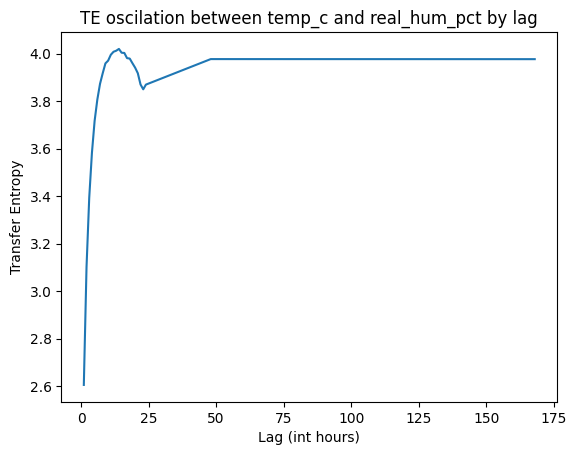

In [34]:
col1 = "temp_c"
col2 = "real_hum_pct"
df_osc_1 = oscilations(transfer_entropy_for_weather, col1, col2)
df_osc_1.set_index("Lag", inplace=True)
df_osc_1.sort_index(inplace=True)
df_osc_1.TE.plot()
plt.title(f"TE oscilation between {col1} and {col2} by lag")
plt.xlabel("Lag (int hours)")
plt.ylabel("Transfer Entropy")
plt.show()

There is an increase of transfer entropy between temperature and real humidity % from 1 hour lag to 50

In [25]:
def get_lag_of_max_entropy_per_pair(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.groupby(["ColumnX1", "ColumnX2"])["TE"].idxmax()
    df_grouped = df.loc[idx]
    return df_grouped

In [26]:
df_transfer_entropy_for_weather = get_lag_of_max_entropy_per_pair(transfer_entropy_for_weather)

In [27]:
df_transfer_entropy_for_weather

,ColumnX1,ColumnX2,Lag,TE,Orientation
233,dew_point_temp_c,press_kpa,168,3.513891,from_1_to_2
143,dew_point_temp_c,real_hum_pct,14,4.029874,from_1_to_2
207,dew_point_temp_c,visibility_km,168,1.311172,from_2_to_1
181,dew_point_temp_c,wind_speed_kmh,168,2.354835,from_2_to_1
299,real_hum_pct,press_kpa,14,3.730116,from_2_to_1
273,real_hum_pct,visibility_km,14,1.163859,from_2_to_1
247,real_hum_pct,wind_speed_kmh,14,2.524392,from_2_to_1
25,temp_c,dew_point_temp_c,168,2.770933,from_1_to_2
129,temp_c,press_kpa,168,3.567835,from_1_to_2
39,temp_c,real_hum_pct,14,4.019584,from_1_to_2
